In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# from sklearn.preprocessing import StandardScaler
import warnings
import neptune
# import networkx as nx


%load_ext autoreload
%autoreload 2

from src.features import *
from src.utils import *
from src.models import *
from src.optimizers import *
from src.loss_functions import *
from src.dataloaders import *
from src.security import NEPTUNE_TOKEN
from src.pipeline_functions import *

plt.style.use("ggplot")
# show all columns
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 45
set_seed(SEED)

In [3]:
stocks = ["SPY", "VTV", "VUG", "VYM", "QQQ", "VNQ", "GLD", "AGG", "SOXX", "OIH", "IYT", "XLF", "XLV", "VOX", "XLY", "XLP", "BND", "BSV", "IEMG", "VEA", "VWO"]
stocks = sorted(stocks)

stock_classes = {'AGG': 'EQUITY', 'GLD': 'COMMODITY', 'IYT': 'EQUITY', 'OIH': 'EQUITY', 'QQQ': 'EQUITY',
                 'SOXX': 'EQUITY', 'SPY': 'EQUITY', 'VNQ': 'REAL_ESTATE', 'VOX': 'EQUITY', 'VTV': 'EQUITY',
                 'VUG': 'EQUITY', 'VYM': 'EQUITY', 'XLF': 'EQUITY', 'XLP': 'EQUITY', 'XLV': 'EQUITY', 'XLY': 'EQUITY',
                 "BND": "FIXED_INCOME", "BSV": "FIXED_INCOME", "IEMG": "EQUITY", "VEA": "EQUITY", "VWO": "EQUITY"
}

classes_color = {'EQUITY': 'salmon', 'COMMODITY': 'cyan', 'FIXED_INCOME': 'lightgreen', "REAL_ESTATE": "lightblue"}

len(stocks)

21

In [4]:
path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = get_data(path, stocks)

AGG Start of history: 2003-09-29
BND Start of history: 2007-04-10
BSV Start of history: 2007-04-10
GLD Start of history: 2004-11-18
IEMG Start of history: 2012-10-24
IYT Start of history: 2004-01-02
OIH Start of history: 2001-02-26
QQQ Start of history: 1999-03-10
SOXX Start of history: 2001-07-13
SPY Start of history: 1993-01-29
VEA Start of history: 2007-07-26
VNQ Start of history: 2004-09-29
VOX Start of history: 2004-09-29
VTV Start of history: 2004-01-30
VUG Start of history: 2004-01-30
VWO Start of history: 2005-03-10
VYM Start of history: 2006-11-16
XLF Start of history: 1998-12-22
XLP Start of history: 1998-12-22
XLV Start of history: 1998-12-22
XLY Start of history: 1998-12-22


In [5]:
nodes_matrix, combined_adj_matrix, cov_adj_matrix, future_return, df_return, df_features = features_pipeline(df_adj_close, df_close, df_high, df_low, df_volume, stocks=stocks)

Features generated and scaled
Return features generated
Correlation and covariance matrices generated
Common index length 2416


100%|██████████| 2416/2416 [04:49<00:00,  8.35it/s]

Adjacency matrices generated
Pipeline finished


In [6]:
TRAIN = 1800
PERIOD = 90 #max window for features' calculation

train_dataset = Dataset(nodes_matrix[:TRAIN], 
                          combined_adj_matrix[:TRAIN], 
                          cov_adj_matrix[:TRAIN], 
                          future_return[:TRAIN])

test_dataset = Dataset(nodes_matrix[TRAIN+PERIOD:],
                            combined_adj_matrix[TRAIN+PERIOD:],
                            cov_adj_matrix[TRAIN+PERIOD:],
                            future_return[TRAIN+PERIOD:])

len(test_dataset)

526

In [7]:
list(range(1,4))

[1, 2, 3]

In [10]:
model_dic = {}

for i in range(1,4):

  model = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=10, pred_window=5, n_heads=i, train_gamma=False, gamma=0.018)
  optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

  _, _ = train(model, optim, train_dataset, epochs=4,
                            eval_func='sharpe_loss', exp_name=f'exp_2405_heads_v{i}', neptune_token=NEPTUNE_TOKEN,
                              neptune_project="aibabynin/graphs", tags=["heads_training"])
  
  model_dic[i] = {"model": model,
                  "optimizer": optim}

  print(f"{i} is trained")

https://app.neptune.ai/aibabynin/graphs/e/GRAP-26
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-26/metadata
1 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-27
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-27/metadata
2 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-28
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in 

In [11]:
for i in range(1,4):
    test_weights_matrix = evaluate(model_dic[i]['model'], test_dataset)
    model_dic[i]['test_weights_matrix'] = test_weights_matrix
    
    print(f"{i} is evaluated")

100%|██████████| 511/511 [00:20<00:00, 25.33it/s]


1 is evaluated


100%|██████████| 511/511 [00:25<00:00, 19.66it/s]


2 is evaluated


100%|██████████| 511/511 [00:31<00:00, 16.28it/s]

3 is evaluated


In [12]:
ret = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].values
index = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].index

returns_matrix = np.zeros((3, len(ret)))

for i in range(3):

    returns_matrix[i] = (ret * model_dic[i+1]['test_weights_matrix']).sum(1)

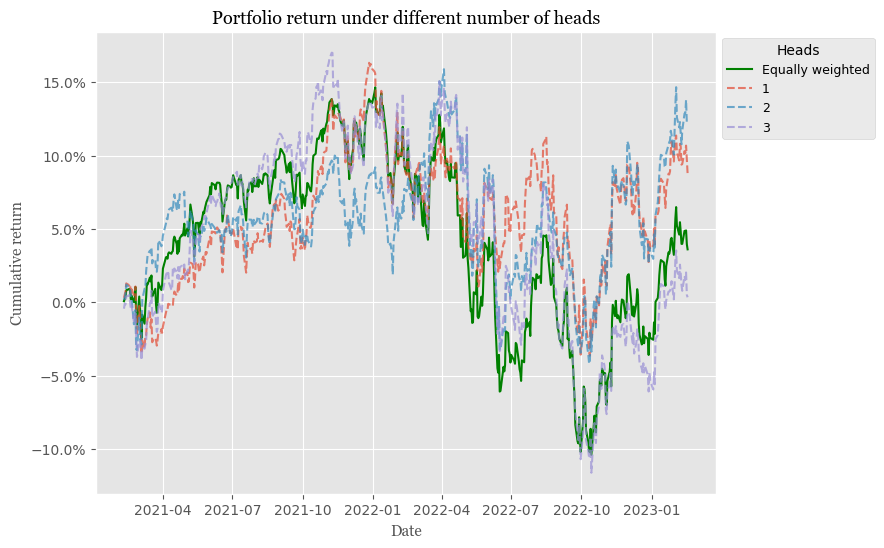

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted')

for i in range(3):
    _ = plt.plot(index, (returns_matrix[i]+1).cumprod()- 1, label=f'{i+1}', alpha=0.7, linestyle='--')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under different number of heads', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Heads', fontsize=9)
plt.show()

In [34]:
counter = np.argmax(((returns_matrix+1).cumprod(1)- 1), axis=0)
np.unique(counter, return_counts=True)

(array([0, 1, 2], dtype=int64), array([168, 158, 185], dtype=int64))

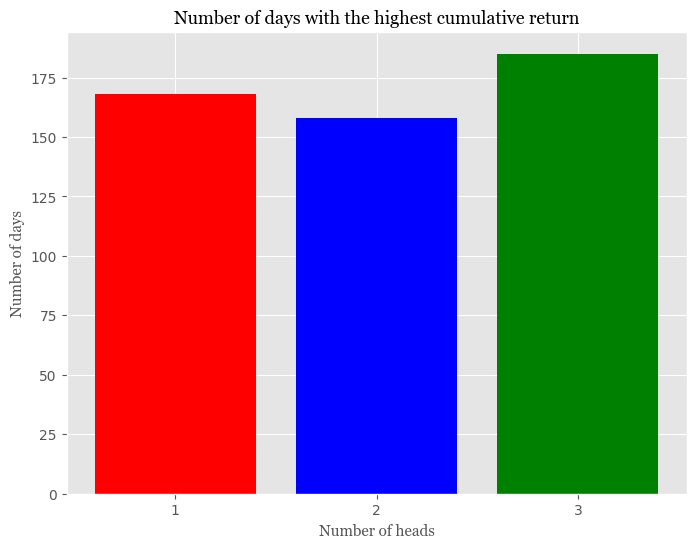

In [39]:
#plot bar plot  with counter
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
# _ = plt.bar(np.unique(counter, return_counts=True)[0], np.unique(counter, return_counts=True)[1], color='green', alpha=0.7)
plt.xticks(np.unique(counter, return_counts=True)[0], labels=np.unique(counter, return_counts=True)[0]+1)

#different colors for different classes
for i, color in zip(range(3), ['red', 'blue', 'green']):
    _ = plt.bar(np.unique(counter, return_counts=True)[0][i], 
                np.unique(counter, return_counts=True)[1][i], color=color)

# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Number of heads', fontsize=11, fontname='Georgia')
plt.ylabel('Number of days', fontsize=11, fontname='Georgia')
plt.title('Number of days with the highest cumulative return', fontsize=13, fontname='Georgia')
plt.show()


In [40]:
#torch save model locally
for i in range(3):
    torch.save(model_dic[i+1]['model'].state_dict(), f"model_heads_{i+1}_sr.pt")
    # print(f"{i+1} model saved")

### max return

In [14]:
model_dic_2 = {}

for i in range(1,4):

  model = GrossModel(num_features=23, num_relations=5, num_assets=21, sample_size=10, pred_window=5, n_heads=i, train_gamma=False, gamma=0.018)
  optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

  _, _ = train(model, optim, train_dataset, epochs=4,
                            eval_func='max_return', exp_name=f'exp_2405_heads_v{i}_max_return', neptune_token=NEPTUNE_TOKEN,
                              neptune_project="aibabynin/graphs", tags=["heads_training", 'max_return'])
  
  model_dic_2[i] = {"model": model,
                  "optimizer": optim}

  print(f"{i} is trained")

https://app.neptune.ai/aibabynin/graphs/e/GRAP-29
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
All 10 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-29/metadata
1 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-30
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-30/metadata
2 is trained
https://app.neptune.ai/aibabynin/graphs/e/GRAP-31
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata i

In [15]:
for i in range(1,4):
    test_weights_matrix = evaluate(model_dic_2[i]['model'], test_dataset)
    model_dic_2[i]['test_weights_matrix'] = test_weights_matrix
    
    print(f"{i} is evaluated")

100%|██████████| 511/511 [00:18<00:00, 27.08it/s]


1 is evaluated


100%|██████████| 511/511 [00:26<00:00, 19.21it/s]


2 is evaluated


100%|██████████| 511/511 [00:33<00:00, 15.35it/s]

3 is evaluated


In [16]:
# ret = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].values
# index = df_return.iloc[TRAIN + PERIOD + model.sample_size + model.pred_window:].index

returns_matrix_2 = np.zeros((3, len(ret)))

for i in range(3):

    returns_matrix_2[i] = (ret * model_dic_2[i+1]['test_weights_matrix']).sum(1)

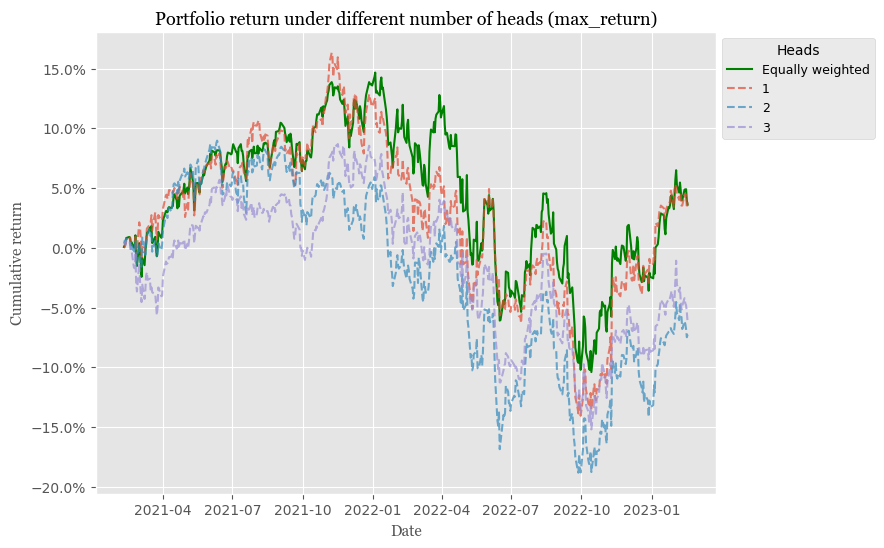

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted')

for i in range(3):
    _ = plt.plot(index, (returns_matrix_2[i]+1).cumprod()- 1, label=f'{i+1}', alpha=0.7, linestyle='--')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under different number of heads (max_return)', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Heads', fontsize=9)
plt.show()

In [30]:
counter = np.argmax(((returns_matrix_2+1).cumprod(1)- 1), axis=0)
np.unique(counter, return_counts=True)

(array([0, 1, 2], dtype=int64), array([447,  48,  16], dtype=int64))

In [41]:
for i in range(3):
    torch.save(model_dic_2[i+1]['model'].state_dict(), f"model_heads_{i+1}_mx_rt.pt")


Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!
